In [1]:
from matplotlib import pyplot as plt
import numpy as np

$\mathbf{\text{Задача 1}}$

In [2]:
def fastest_decent(A, f, eps, N_MAX = int(1e7)):
    A = np.array(A)
    f = np.array(f)
    n = f.shape[0]
    x_old = np.zeros(n)
    x_new = np.zeros(n)
    iters = 0
    for i in range(N_MAX):
        iters += 1
        r = (A@x_old.reshape(n, 1) - f.reshape(n, 1))
        tau = 0.5 * (r.T@r) / ((A@r).T@r)
        x_new = x_old - tau * r.T
        if np.linalg.norm(x_new - x_old) < eps:
            break
        x_old = x_new.copy()
    return x_new, iters

In [3]:
A = [[1, 1],
     [0, 1]
    ]
f = [2, 2]
fastest_decent(A, f, 0.001)

(array([[7.99274397e-04, 1.99999061e+00]]), 13)

In [4]:
def Hilbert_problem(n):
    A = np.zeros([n, n])
    f = np.zeros(n)
    for i in range(n):
        for j in range(n):
            A[i, j] = 1 / (i + j + 1)
    for i in range(n):
        f[i] = np.sum(A, axis=0)[i]
    return A, f

In [5]:
A, f = Hilbert_problem(10)
fastest_decent(A, f, 0.001)

(array([[1.00440492, 0.95323084, 1.01678109, 1.04630703, 1.04824448,
         1.0337055 , 1.01002373, 0.98160329, 0.95105014, 0.91990308]]), 47)

Исследуем скорость сходимости от n

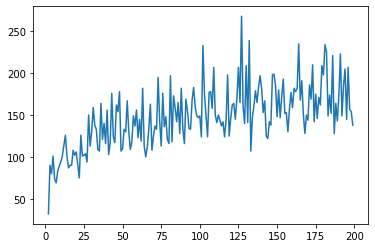

In [6]:
results = []
N = 200
for i in range(2, N):
    A, f = Hilbert_problem(i)  
    x, iters = fastest_decent(A, f, 0.0001)
    results.append(iters)
plt.plot(np.array(range(2, N)), results)

Видно, что количество необходимых итераций в среднем растет очень медленно с ростом размерности задачи

$\mathbf{\text{Задача 2}}$

Реализуем метод сопряженных градиентов и сравним его на той же задаче с методом наискорейшего спуска

In [21]:
def conj_grad(A, f, eps, N_ITER_MAX = int(1e7)):
    A = np.array(A)
    f = np.array(f)
    n = f.shape[0]
    f = f.reshape([n, 1])
    x = np.zeros([n, 1])
    r = A@x - f
    p = A@x - f
    iters = 0
    for i in range(N_ITER_MAX):
        alpha = (r.T @ r) / (p.T @ A @ p)
        x = x - alpha * p
        tmp = r.T @ r
        r = A @x - f
        beta = (r.T @ r) / tmp
        p = r + beta * p
        iters += 1
        if np.linalg.norm(r) < eps:
            break
    return x.reshape(1, n), iters
        

In [34]:
A, f = Hilbert_problem(10)
conj_grad(A, f, 0.0000001)

(array([[1.00004424, 0.99917105, 1.00311286, 0.99780729, 0.99733449,
         0.99981427, 1.00223552, 1.00285626, 1.00099486, 0.99657916]]), 6)

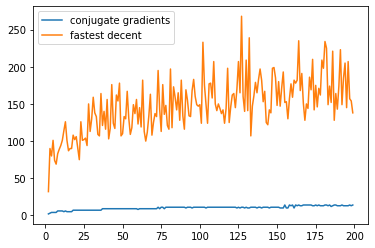

In [30]:
resultsF = []
resultsC = []
N = 200
for i in range(2, N):
    A, f = Hilbert_problem(i)  
    x, iters = fastest_decent(A, f, 0.0001)
    resultsF.append(iters)
    x, iters = conj_grad(A, f, 1e-6)
    resultsC.append(iters)
plt.plot(np.array(range(2, N)), resultsC, label='conjugate gradients')
plt.plot(np.array(range(2, N)), resultsF, label='fastest decent')
# plt.yscale('log')
plt.legend()

Для данной задачи метод сопряженных градиентов работает невероятно быстро. В десятки раз быстрее метода наискорейшего спуска.

$\mathbf{\text{Задача 3}}$

Для подробного исследования напишем функции так, чтобы они еще и выдавали евлидовы нормы всех невязок

In [106]:
def fastest_decent_r(A, f, eps, N_MAX = int(1e7)):
    A = np.array(A)
    f = np.array(f)
    n = f.shape[0]
    x_old = np.zeros(n)
    x_new = np.zeros(n)
    iters = 0
    r = A@x_old.reshape(n, 1) - f.reshape(n, 1)
    r_l = []
    for i in range(N_MAX):
        iters += 1
        r_l.append(np.linalg.norm(r))
        r = (A@x_old.reshape(n, 1) - f.reshape(n, 1))
        tau = 0.5 * (r.T@r) / ((A@r).T@r)
        x_new = x_old - tau * r.T
        if np.linalg.norm(x_new - x_old) < eps:
            r_l.append(np.linalg.norm(r))
            break
        x_old = x_new.copy()
    return x_new, r_l

def conj_grad_r(A, f, eps, N_ITER_MAX = int(1e7)):
    A = np.array(A)
    f = np.array(f)
    n = f.shape[0]
    f = f.reshape([n, 1])
    x = np.zeros([n, 1])
    r = A@x - f
    p = A@x - f
    iters = 0
    r_l = []
    for i in range(N_ITER_MAX):
        alpha = (r.T @ r) / (p.T @ A @ p)
        x = x - alpha * p
        tmp = r.T @ r
        r_l.append(np.linalg.norm(r))
        r = A @x - f
        beta = (r.T @ r) / tmp
        p = r + beta * p
        iters += 1
        if np.linalg.norm(r) < eps:
            r_l.append(np.linalg.norm(r))
            break
    return x.reshape(1, n), r_l
    

In [111]:
N = 5
A1 = np.random.uniform(-1, 1, size = [N, N])
A1 = (A1.T + A1) / 2 + np.eye(N) * 3
A2 = np.random.uniform(-1, 1, size = [N, N])
A2 = (A2.T + A2) / 2 + np.eye(N) * 3
b1 = np.random.uniform(-1, 1, size = N)
b2 = np.random.uniform(-1, 1, size = N)
# Для случайной матрицы оказалось, что метод наискорейшего спуска как правило расходится. Если же добавить
# относительно небольшое диагональное слогаемое, то метод начинает сходиться

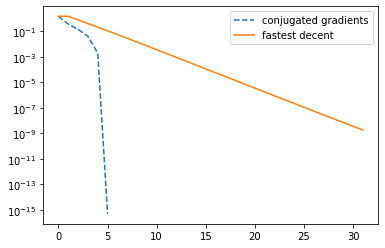

In [114]:
# A1, b1
x, rc = conj_grad_r(A1, b1, 1e-9)
x, rf = fastest_decent_r(A1, b1, 1e-9)
plt.plot(np.array(range(len(rc))), rc, '--', label='conjugated gradients')
plt.plot(np.array(range(len(rf))), rf, label='fastest decent')
plt.yscale('log')
plt.legend()

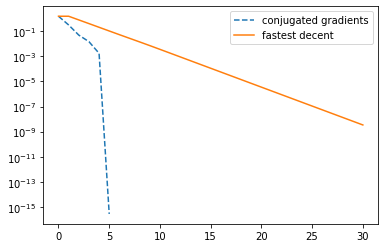

In [115]:
# A2, b2
x, rc = conj_grad_r(A2, b2, 1e-9)
x, rf = fastest_decent_r(A2, b2, 1e-9)
plt.plot(np.array(range(len(rc))), rc, '--', label='conjugated gradients')
plt.plot(np.array(range(len(rf))), rf, label='fastest decent')
plt.yscale('log')
plt.legend()

$\mathbf{\text{Задача 4}}$

На данных картинках замкнутые линии обозначуют линии уровня: $\Phi(x) = const$. Так как на первой картинке движение происходит перпендикулярно линиям уровня, на ней изображен метод наискорейшего спуска. Тогда на второй картинке изображен метод сопряженных градиентов. Метод сопряженных градиентов строится так, что на каждом шаге новая невязка перпендикулярна всем остальным. Таким образом n-ая невязка обязана быть равной нулю. То есть для матрицы NxN точное решение достигается за N шагов (если не учитывать ошибки округлений)  

$\mathbf{\text{Задача 5}}$

Овражность плоха тем, что вдоль разных направлений оптимальными являются шаги разных масштабов.
Если шаг мал, то это приведет к огромному числу итераций при движении вдоль оврага. Если шаг велик, 
то это может привести к бесконечным скачкам через овраг при движении поперек него.

Овражный характер функции не связан напрямую с величиной минимального спектрального числа соответствующей матрицы, а связан с ее числом обусловленности, которое как раз и задает отношение "масшатабов" оврага. Чем больше число обусловленности, тем более овражная функция.

Что касается покоординатного спуска в овражном случае, из рисунка можно сделать вывод, что скорость его сходимости сильно зависит от начального приближения.
